# Multiple Ensemble strategies

This notebook tries different ensemble strategies, and outputs several submission files, which can be submitted separately.

Most of the known solutions are very correlated to each other, though, so ensembling may not improve things much.

In [1]:
import pandas as pd

In [2]:
model_dict = {
    "df1_adaptive": ("/kaggle/input/caloriecast-adaptive-ensemble-engine-for-s5e5/submission.csv", 0.05670),
    "df2_ensemble": ("/kaggle/input/ensemble-of-solutions/submission.csv", 0.05668),
    "df3_log_blend": ("/kaggle/input/ps-s5e5-log-blended-cat-xgboost-with-50-fold-cv/ensemble_submission.csv", 0.05670),
    "df4_cross_masked": ("/kaggle/input/ps-s5e5-cross-masked-ensemble/submission.csv", 0.05680),
    "df5_triple": ("/kaggle/input/ps-s5e5-calorie-prediction-ensemble/submission.csv", 0.05667),
    "df6_cat_xgb_fe": ("/kaggle/input/ps-s5e5-catboost-xgboost-feature-engineering/submission.csv", 0.05679),
    "df7_pce": ("/kaggle/input/pce-v1/submission.csv", 0.05668),
    "df8_best_fe": ("/kaggle/input/calorie-best-fe/submission.csv", 0.05667),
    "df11_gender": ("/kaggle/input/calorie-expenditure-female-vs-male/submission.csv", 0.05667),
    "df12_kmeans": ("/kaggle/input/kmeans-clustering-based-fe-improves-cv-lb-scores/submission.csv", 0.05695),
    "df13_meta": ("/kaggle/input/s5e5-xgb-cat-lgbm-meta-models/submission.csv", 0.05695),
}


In [3]:
def load_model_predictions(model_dict):
    """
    Loads model predictions from a dict of {model_name: (csv_path, score)}.

    Returns:
    - loaded_models: dict of {model_name: (DataFrame, score)}
    """
    loaded_models = {}
    for name, (path, score) in model_dict.items():
        try:
            df = pd.read_csv(path)
            assert 'Calories' in df.columns, f"'Calories' column not found in {name}"
            loaded_models[name] = (df, score)  # <<< return tuple, not just df
            print(f"Loaded {name} (LB {score:.5f})")
        except Exception as e:
            print(f"❌ Failed to load {name}: {e}")
    return loaded_models


In [4]:
loaded_models = load_model_predictions(model_dict)
#loaded_models

Loaded df1_adaptive (LB 0.05670)
Loaded df2_ensemble (LB 0.05668)
Loaded df3_log_blend (LB 0.05670)
Loaded df4_cross_masked (LB 0.05680)
Loaded df5_triple (LB 0.05667)
Loaded df6_cat_xgb_fe (LB 0.05679)
Loaded df7_pce (LB 0.05668)
Loaded df8_best_fe (LB 0.05667)
Loaded df11_gender (LB 0.05667)
Loaded df12_kmeans (LB 0.05695)
Loaded df13_meta (LB 0.05695)


## Simple ENSEMBLE strategies

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def safe_ensemble_named(model_dict, sample_submission, output_prefix="submission"):
    """
    Generate ensemble predictions from a dict of named model submissions.
    
    Args:
        model_dict: dict of {model_name: (DataFrame, score)} with 'Calories' column
        sample_submission: DataFrame with 'Calories' column to write outputs into
        output_prefix: prefix for the saved CSV files
    """
    model_names = list(model_dict.keys())
    model_dfs = [v[0] for v in model_dict.values()]
    model_scores = [v[1] for v in model_dict.values()]

    all_preds = np.stack([df['Calories'].values for df in model_dfs], axis=1)
    print(f"Loaded {len(model_dfs)} models for ensembling.")

    # --- 1. Correlation heatmap ---
    corr_matrix = np.corrcoef(all_preds.T)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".4f", xticklabels=model_names, yticklabels=model_names, cmap='coolwarm')
    plt.title("Correlation Between Model Predictions")
    plt.tight_layout()
    plt.show()

    # --- 2. Ensemble Strategies ---

    # Mean
    sample_submission['Calories'] = np.mean(all_preds, axis=1)
    sample_submission.to_csv(f"{output_prefix}_mean.csv", index=False)

    # Median
    sample_submission['Calories'] = np.median(all_preds, axis=1)
    sample_submission.to_csv(f"{output_prefix}_median.csv", index=False)

    # Trimmed Mean (exclude top 2 and bottom 2)
    sorted_preds = np.sort(all_preds, axis=1)
    trimmed_preds = np.mean(sorted_preds[:, 2:-2], axis=1)
    sample_submission['Calories'] = trimmed_preds
    sample_submission.to_csv(f"{output_prefix}_trimmed_mean.csv", index=False)

    # Weighted by inverse standard deviation
    stds = np.std(all_preds, axis=0)
    weights_std = 1 / (stds + 1e-6)
    weights_std /= weights_std.sum()
    weighted_std_preds = (all_preds * weights_std).sum(axis=1)
    sample_submission['Calories'] = weighted_std_preds
    sample_submission.to_csv(f"{output_prefix}_weighted_std.csv", index=False)

    # Score-weighted average (lower score = better)
    eps = 1e-6
    weights_score = 1 / (np.array(model_scores) + eps)
    weights_score /= weights_score.sum()
    weighted_score_preds = (all_preds * weights_score).sum(axis=1)
    sample_submission['Calories'] = weighted_score_preds
    sample_submission.to_csv(f"{output_prefix}_weighted_score.csv", index=False)

    # Softmax-weighted average (based on -score)
    temp_scores = -np.array(model_scores)
    weights_softmax = np.exp(temp_scores - temp_scores.max())
    weights_softmax /= weights_softmax.sum()
    weighted_softmax_preds = (all_preds * weights_softmax).sum(axis=1)
    sample_submission['Calories'] = weighted_softmax_preds
    sample_submission.to_csv(f"{output_prefix}_weighted_softmax.csv", index=False)

    # --- 3. Leave-One-Out Median Ensemble Analysis ---
    print("\nLeave-One-Out Median Ensemble Influence:")
    for i, name in enumerate(model_names):
        partial_preds = np.delete(all_preds, i, axis=1)
        median_preds = np.median(partial_preds, axis=1)
        print(f"Without {name}: mean = {median_preds.mean():.5f}, std = {median_preds.std():.5f}")

    print("\n✅ Ensemble submissions saved.")


Loaded df1_adaptive (LB 0.05670)
Loaded df2_ensemble (LB 0.05668)
Loaded df3_log_blend (LB 0.05670)
Loaded df4_cross_masked (LB 0.05680)
Loaded df5_triple (LB 0.05667)
Loaded df6_cat_xgb_fe (LB 0.05679)
Loaded df7_pce (LB 0.05668)
Loaded df8_best_fe (LB 0.05667)
Loaded df11_gender (LB 0.05667)
Loaded df12_kmeans (LB 0.05695)
Loaded df13_meta (LB 0.05695)
Loaded 11 models for ensembling.


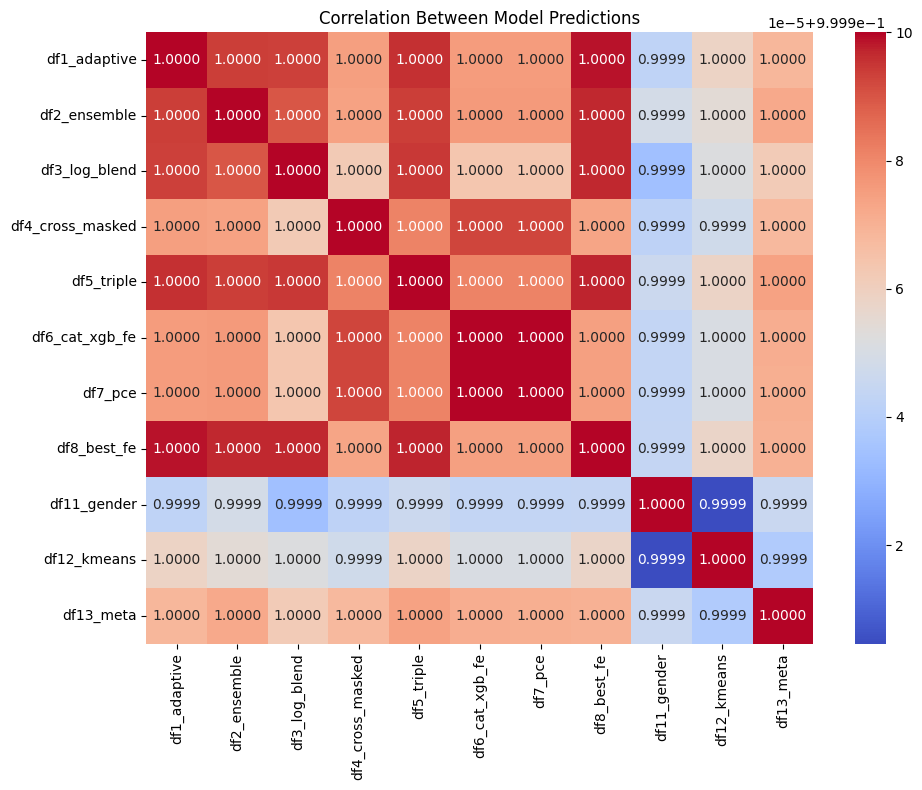


Leave-One-Out Median Ensemble Influence:
Without df1_adaptive: mean = 88.15664, std = 62.23959
Without df2_ensemble: mean = 88.15972, std = 62.24937
Without df3_log_blend: mean = 88.15607, std = 62.24077
Without df4_cross_masked: mean = 88.15270, std = 62.23361
Without df5_triple: mean = 88.15467, std = 62.23771
Without df6_cat_xgb_fe: mean = 88.15271, std = 62.23371
Without df7_pce: mean = 88.15272, std = 62.23373
Without df8_best_fe: mean = 88.15742, std = 62.24295
Without df11_gender: mean = 88.15306, std = 62.23498
Without df12_kmeans: mean = 88.15341, std = 62.23594
Without df13_meta: mean = 88.15249, std = 62.23381

✅ Ensemble submissions saved.


In [6]:
ground_truth = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")
loaded_models = load_model_predictions(model_dict)
safe_ensemble_named(loaded_models, ground_truth.copy())


## Focusing on differentiation

Since most submission files are identicaly, here we try to select a more diverse subset, by minimizing pairwise correlation.

In [7]:
import numpy as np
from itertools import combinations
from tqdm import tqdm

def select_diverse_models_named(model_dict, max_models=6, strategy="median"):
    """
    Selects a diverse subset of models by minimizing pairwise correlation.

    Parameters:
    - model_dict: dict of {model_name: (DataFrame, score)} with 'Calories' column
    - max_models: number of models to select for the ensemble
    - strategy: 'mean' or 'median' for ensembling

    Returns:
    - selected_names: list of selected model names
    - ensemble_predictions: numpy array of ensemble output
    """
    model_names = list(model_dict.keys())
    model_dfs = [v[0] for v in model_dict.values()]  # Extract DataFrames
    preds = np.stack([df['Calories'].values for df in model_dfs], axis=1)
    corr_matrix = np.corrcoef(preds.T)

    # Brute-force optimal subset (only if small)
    if len(model_dfs) <= 12 and max_models <= 6:
        best_score = np.inf
        best_combo = None
        for combo in tqdm(list(combinations(range(len(model_dfs)), max_models)), desc="Searching subsets"):
            subset_corr = corr_matrix[np.ix_(combo, combo)]
            avg_corr = subset_corr[np.triu_indices(len(combo), k=1)].mean()
            if avg_corr < best_score:
                best_score = avg_corr
                best_combo = combo
        selected_indices = list(best_combo)
    else:
        # Greedy selection for larger sets
        selected_indices = [0]
        for _ in range(max_models - 1):
            rest = [i for i in range(len(model_dfs)) if i not in selected_indices]
            best_candidate = None
            best_avg_corr = np.inf
            for i in rest:
                temp_indices = selected_indices + [i]
                temp_corr = corr_matrix[np.ix_(temp_indices, temp_indices)]
                avg_corr = temp_corr[np.triu_indices(len(temp_indices), k=1)].mean()
                if avg_corr < best_avg_corr:
                    best_avg_corr = avg_corr
                    best_candidate = i
            selected_indices.append(best_candidate)

    selected_names = [model_names[i] for i in selected_indices]
    selected_preds = preds[:, selected_indices]

    print(f"\nSelected models: {selected_names}")
    print("Average correlation among them:",
          corr_matrix[np.ix_(selected_indices, selected_indices)][np.triu_indices(len(selected_indices), k=1)].mean())

    # Compute ensemble
    if strategy == "median":
        ensemble_preds = np.median(selected_preds, axis=1)
    else:
        ensemble_preds = np.mean(selected_preds, axis=1)

    return selected_names, ensemble_preds


In [8]:
selected_names, ensemble = select_diverse_models_named(loaded_models, max_models=6, strategy="median")

ground_truth = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")
ground_truth['Calories'] = ensemble
ground_truth.to_csv("submission_diverse_ensemble.csv", index=False)


Searching subsets: 100%|██████████| 462/462 [00:00<00:00, 18794.49it/s]



Selected models: ['df3_log_blend', 'df4_cross_masked', 'df7_pce', 'df11_gender', 'df12_kmeans', 'df13_meta']
Average correlation among them: 0.9999518033583447


## EDA

Here some more visualization of the models and their performances

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_rowwise_disagreement(model_dict, top_n=10):
    """
    Plots the rows with highest prediction disagreement across models.

    Args:
        model_dict: dict of {name: (df, score)} with 'Calories' column
        top_n: number of most variable rows to plot
    """
    model_names = list(model_dict.keys())
    model_dfs = [v[0] for v in model_dict.values()]
    preds = np.stack([df['Calories'].values for df in model_dfs], axis=1)
    
    row_std = np.std(preds, axis=1)
    top_indices = np.argsort(row_std)[-top_n:][::-1]

    print(f"\nTop {top_n} most disagreeing rows (by std):")
    for i in top_indices:
        print(f"Row {i}: std = {row_std[i]:.6f}, mean = {preds[i].mean():.4f}")

    plt.figure(figsize=(10, 6))
    for model_idx, name in enumerate(model_names):
        plt.plot(top_indices, preds[top_indices, model_idx], marker='o', label=name)
    plt.xlabel("Row index (high disagreement)")
    plt.ylabel("Predicted Calories")
    plt.title(f"Top {top_n} Rows with Highest Disagreement Across Models")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



Top 10 most disagreeing rows (by std):
Row 30254: std = 18.803431, mean = 40.3913
Row 109124: std = 16.254360, mean = 193.4986
Row 19455: std = 14.475718, mean = 110.7168
Row 384: std = 11.304757, mean = 95.6277
Row 82571: std = 11.082326, mean = 159.7538
Row 234327: std = 9.987469, mean = 182.6414
Row 63582: std = 8.486503, mean = 190.3394
Row 42151: std = 7.834694, mean = 72.6411
Row 72091: std = 7.547042, mean = 39.2063
Row 24606: std = 7.232418, mean = 121.0722


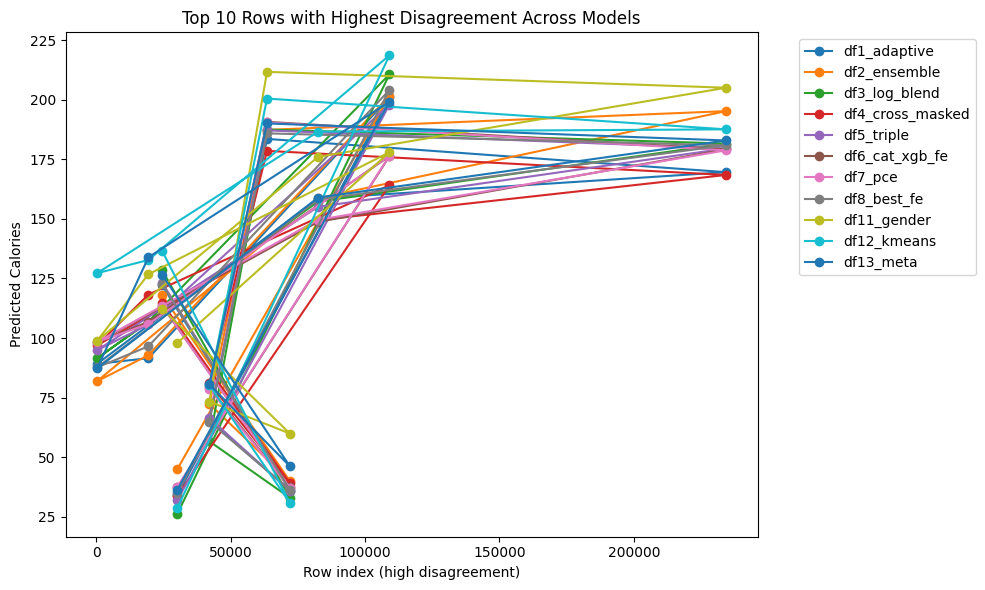

In [10]:
plot_rowwise_disagreement(loaded_models, top_n=10)


In [11]:
from sklearn.decomposition import PCA
import seaborn as sns

def plot_model_prediction_pca(model_dict):
    """
    Plots PCA of model predictions to show similarity between models.

    Args:
        model_dict: dict of {name: (df, score)} with 'Calories' column
    """
    model_names = list(model_dict.keys())
    model_dfs = [v[0] for v in model_dict.values()]
    model_scores = [v[1] for v in model_dict.values()]
    
    preds = np.stack([df['Calories'].values for df in model_dfs], axis=1).T  # shape: (models, samples)

    pca = PCA(n_components=2)
    coords = pca.fit_transform(preds)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=model_scores, cmap="viridis", s=80)
    for i, name in enumerate(model_names):
        plt.text(coords[i, 0], coords[i, 1], name, fontsize=9, ha='right')
    plt.colorbar(scatter, label="Leaderboard Score (lower is better)")
    plt.title("PCA of Model Predictions (each point is a model)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


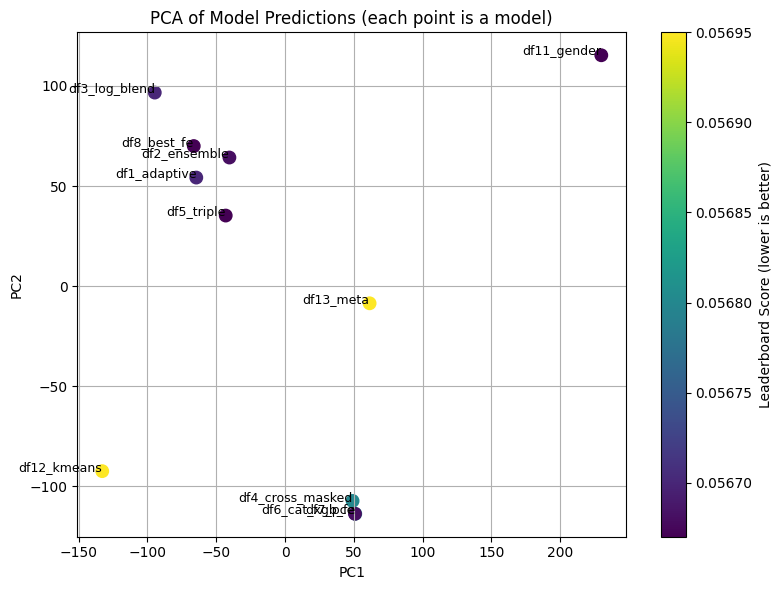

In [12]:
plot_model_prediction_pca(loaded_models)


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction_agreement_hist(model_dict, tolerance=0.01):
    """
    Plots a histogram showing how many models agree within a given tolerance per row.

    Args:
        model_dict: dict of {name: (df, score)} with 'Calories' column
        tolerance: max absolute difference allowed for predictions to be considered 'in agreement'
    """
    model_names = list(model_dict.keys())
    model_dfs = [v[0] for v in model_dict.values()]
    preds = np.stack([df['Calories'].values for df in model_dfs], axis=1)  # shape: (rows, models)

    # For each row, count how many predictions are within 'tolerance' of the row's median
    medians = np.median(preds, axis=1, keepdims=True)
    agreement_mask = np.abs(preds - medians) <= tolerance
    agreement_counts = np.sum(agreement_mask, axis=1)  # number of agreeing models per row

    # Plot
    plt.figure(figsize=(8, 5))
    plt.hist(agreement_counts, bins=np.arange(0.5, len(model_names) + 1.5, 1), edgecolor='black')
    plt.xlabel(f"# of Models in Agreement (±{tolerance})")
    plt.ylabel("Number of Rows")
    plt.title(f"Agreement Across Models Per Row (Tolerance ±{tolerance})")
    plt.xticks(range(1, len(model_names) + 1))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


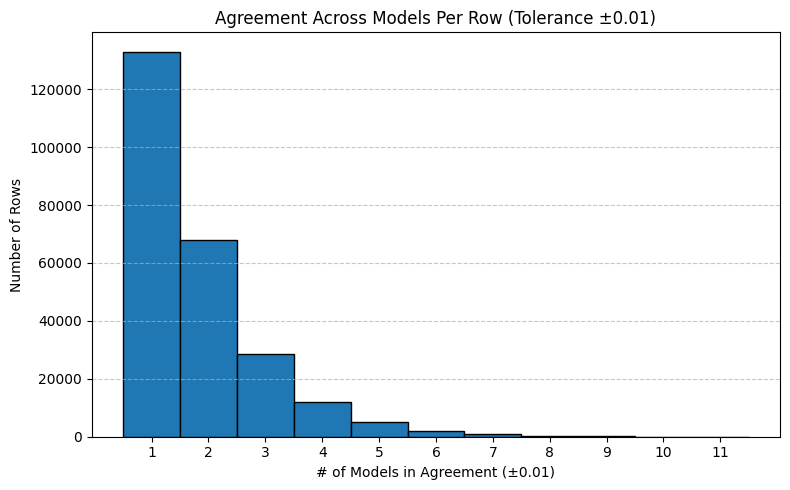

In [14]:
plot_prediction_agreement_hist(loaded_models, tolerance=0.01)


## Adaptive row-wise ensemble

The plot generated by the plot_rowwise_disagreement is funny. It seems most of the disagreement is in the first rows of the submission file. Maybe we are overfitting?

This new strategy uses a row-by-row ensemble, based on the disagreement across models.

In [15]:
import numpy as np
import pandas as pd

def adaptive_rowwise_ensemble(model_dict, sample_submission, threshold_percentile=90, output_path="submission_adaptive.csv"):
    """
    Uses a per-row strategy to blend predictions based on disagreement across models.
    Median is used for high-disagreement rows; mean otherwise.

    Args:
        model_dict: dict of {name: (DataFrame, score)} with 'Calories' column
        sample_submission: DataFrame with 'Calories' column to write outputs into
        threshold_percentile: percentile of std above which rows are considered 'uncertain'
        output_path: path to save the adaptive ensemble submission
    """
    model_dfs = [v[0] for v in model_dict.values()]
    preds = np.stack([df['Calories'].values for df in model_dfs], axis=1)  # shape: (rows, models)

    row_std = np.std(preds, axis=1)
    threshold = np.percentile(row_std, threshold_percentile)
    is_uncertain = row_std > threshold

    # Apply adaptive strategy
    median_preds = np.median(preds, axis=1)
    mean_preds = np.mean(preds, axis=1)
    final_preds = np.where(is_uncertain, median_preds, mean_preds)
    # Output
    sample_submission['Calories'] = final_preds
    sample_submission.to_csv(output_path, index=False)

    print(f"\n✅ Adaptive row-wise ensemble saved to: {output_path}")
    print(f"{np.sum(is_uncertain)} rows ({100 * np.mean(is_uncertain):.2f}%) used median due to high disagreement (std > {threshold:.4f})")


In [16]:
ground_truth = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")
adaptive_rowwise_ensemble(loaded_models, ground_truth.copy(), threshold_percentile=90, output_path="submission_adaptive.csv")



✅ Adaptive row-wise ensemble saved to: submission_adaptive.csv
25000 rows (10.00%) used median due to high disagreement (std > 0.4895)


## Hill Climbing ENSEMBLE

In [17]:
import numpy as np
import pandas as pd

def hill_climbing_ensemble(model_dict, sample_submission, max_models=6, strategy="mean", output_path="submission_hillclimb.csv"):
    """
    Greedy hill climbing ensemble using leaderboard scores as guidance.

    Args:
        model_dict: dict of {name: (DataFrame, score)} with 'Calories' column
        sample_submission: base submission file to write output
        max_models: number of models to include in ensemble
        strategy: 'mean' or 'median' to combine predictions
        output_path: path to save final submission
    """
    model_items = sorted(model_dict.items(), key=lambda x: x[1][1])  # sort by score ascending (lower is better)

    all_names = [name for name, _ in model_items]
    all_preds = {name: df['Calories'].values for name, (df, _) in model_items}

    selected = [all_names[0]]  # start with best model
    current_preds = np.array(all_preds[selected[0]])

    print(f"Starting hill climbing with: {selected[0]}")

    for _ in range(1, max_models):
        best_candidate = None
        best_metric = np.inf  # simulate LB score

        for name in all_names:
            if name in selected:
                continue
            temp_models = selected + [name]
            stacked = np.stack([all_preds[n] for n in temp_models], axis=1)

            if strategy == "median":
                temp_ensemble = np.median(stacked, axis=1)
            else:
                temp_ensemble = np.mean(stacked, axis=1)

            # Simulate proxy "score": mean disagreement with best model
            diff = np.abs(temp_ensemble - all_preds[all_names[0]])
            proxy_score = diff.mean()

            if proxy_score < best_metric:
                best_metric = proxy_score
                best_candidate = name

        if best_candidate:
            selected.append(best_candidate)
            print(f"Added {best_candidate} → proxy score: {best_metric:.5f}")

    # Final ensemble
    final_preds = np.stack([all_preds[n] for n in selected], axis=1)
    if strategy == "median":
        ensemble_output = np.median(final_preds, axis=1)
    else:
        ensemble_output = np.mean(final_preds, axis=1)

    sample_submission['Calories'] = ensemble_output
    sample_submission.to_csv(output_path, index=False)
    print(f"\n✅ Hill climbing ensemble saved to: {output_path}")
    print(f"Selected models: {selected}")


In [18]:
ground_truth = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")
hill_climbing_ensemble(loaded_models, ground_truth.copy(), max_models=6, strategy="mean")


Starting hill climbing with: df5_triple
Added df8_best_fe → proxy score: 0.04747
Added df1_adaptive → proxy score: 0.06653
Added df4_cross_masked → proxy score: 0.06936
Added df3_log_blend → proxy score: 0.05796
Added df2_ensemble → proxy score: 0.06285

✅ Hill climbing ensemble saved to: submission_hillclimb.csv
Selected models: ['df5_triple', 'df8_best_fe', 'df1_adaptive', 'df4_cross_masked', 'df3_log_blend', 'df2_ensemble']
